# Recommender Systems (Collaborative Filtering)

This notebook is based on fastai's **[Chapter 8](https://github.com/fastai/fastbook/blob/master/08_collab.ipynb)**.

Please read that chapter before looking at this review.

*I suggest opening this notebook in Colab (where it can be easier to use GPU).*
*If you want to run it locally, set up the **deep-learning** environment in your terminal with `conda env create -f environment.yml` and activate it in your preferred IDE.*

In [1]:
### FOR COLAB USERS ###
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.9 MB/s eta 0:00:00
Mounted at /content/gdrive


In [ ]:
# ### FOR LOCAL USERS ###
# import fastai
# print(fastai.__version__)

# ! pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()

In [3]:
from fastbook import *
from fastai.collab import *
from fastai.tabular.all import *

# Data
Movie rankings (movie ID, user ID, numeric rating)

In [4]:
path = untar_data(URLs.ML_100k)

In [5]:
# user ratings
ratings = pd.read_csv(
  path/'u.data', delimiter='\t', header=None,
  names=['user','movie','rating','timestamp']
)

ratings.head(1)

,user,movie,rating,timestamp
0,196,242,3,881250949


In [6]:
# movie ids
movies = pd.read_csv(
  path/'u.item',  delimiter='|', encoding='latin-1',
  usecols=(0,1), names=('movie','title'), header=None
)

movies.head(1)

,movie,title
0,1,Toy Story (1995)


In [7]:
# merge the two dfs together
ratings = ratings.merge(movies)
ratings.head(1)

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)


In [8]:
# dataloaders
  # By default, it takes the first column for the user,
  # the second column for the item (here our movies),
  # and the third column for the ratings

dls = CollabDataLoaders.from_df(
  ratings, # df
  # user_name -- default
  item_name='title', # want to switch the movie id number to the title name
  # rating_name -- default
  bs=64
)

dls.show_batch()

,user,title,rating
0,542,My Left Foot (1989),4
1,422,Event Horizon (1997),3
2,311,"African Queen, The (1951)",4
3,595,Face/Off (1997),4
4,617,Evil Dead II (1987),1
5,158,Jurassic Park (1993),5
6,836,Chasing Amy (1997),3
7,474,Emma (1996),3
8,466,Jackie Chan's First Strike (1996),3
9,554,Scream (1996),3


### Batch

In [9]:
# x = [user ids, movie ids]
# y = ratings
x,y = dls.one_batch()
print(x.shape, y.shape)

torch.Size([64, 2]) torch.Size([64, 1])


In [10]:
# x has two columns
  # column 1 = user ids
  # column 2 = movie ids
sample_x = x[0:5,:]
sample_x_col1 = x[0:5, 0]
sample_x_col2 = x[0:5, 1]

print("sample of independent var:\n",sample_x)
print()
print("user ids:",sample_x_col1)
print("movie ids:",sample_x_col2)

sample of independent var:
 tensor([[ 661,  659],
        [ 861,  730],
        [ 766,    8],
        [  13, 1153],
        [ 429, 1185]])

user ids: tensor([661, 861, 766,  13, 429])
movie ids: tensor([ 659,  730,    8, 1153, 1185])


In [11]:
# y are the ratings
sample_y = y[0:5]
sample_y

tensor([[4],
        [4],
        [4],
        [1],
        [3]], dtype=torch.int8)

### Sample

In [12]:
# sample
sample_x = x[0:5,:] # choose five user-movie pairs
sample_y = y[0:5] # ratings of those five user-movie pairs

for i in range(0,5):
  user_id = sample_x[i,0]
  movie_id = sample_x[i,1]
  rating = sample_y[i]

  print(f"user {user_id} watched movie {movie_id} and rated it {int(rating)}")

user 661 watched movie 659 and rated it 4
user 861 watched movie 730 and rated it 4
user 766 watched movie 8 and rated it 4
user 13 watched movie 1153 and rated it 1
user 429 watched movie 1185 and rated it 3


# Aside: Embeddings

## Assuming we know the latent features
- Latent factors: genre, age, preferred directors / actors
- Assume each movie has a score from -1 to +1 for each of these factors, based on how much the movie matches the factors
- Take the dot product of the vector of user scores (of the factors) and a vector of movie scores (of the factors)
- Dot product = multipy the elements of the two vectors together and sum the result

In [13]:
# factors -- same for movie and user embeddings
factors = ['sci_fi','action','old_movie']

In [14]:
# two movies
last_skywalker = np.array([0.98,0.9,-0.9]) # very sci-fi, very action, not old at all
casablanca = np.array([-0.99,-0.3,0.8]) # not at all sci-fi, less action, very old

In [15]:
# one user
user1 = np.array([0.9,0.8,-0.6]) # user likes sci-fi, likes action, doesn't like old movies

In [16]:
# dot product -- find a match "score" between the user and each of the movies
user1_last_skywalker_match = (user1*last_skywalker).sum()
user1_casablanca_match = (user1*casablanca).sum()

print(user1_last_skywalker_match.round(2),user1_casablanca_match.round(2))

2.14 -1.61


## FastAI Latent Factor Representation
Represent our movie and user latent factor tables as simple matrices

### Create user and movie matrices

In [17]:
# get user and movie title matrices
classes = dls.classes
print(classes.keys())

dict_keys(['user', 'title'])


In [18]:
# number of users, number of movies
n_users = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
print(n_users, n_movies)

944 1665


In [19]:
# example of user and title classes
print(dls.classes['user'][0:5])
print(dls.classes['title'][0:5])

['#na#', 1, 2, 3, 4]
['#na#', "'Til There Was You (1997)", '1-900 (1994)', '101 Dalmatians (1996)', '12 Angry Men (1957)']


### Create embeddings (latent factors)
- Embeddings = a random vector of a certain length that represents the latent favots of movies / users
- These are learnable parameters that the model will optimize.
- Here, we are choosing 5 latent variables that are used to represent users and movies (same latent factors for both)

#### Randomly initialize latent factor (parameter) values

In [20]:
# choose the number of latent factors
n_factors = 5

# initialize random weights
user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

print(user_factors.shape, movie_factors.shape)

torch.Size([944, 5]) torch.Size([1665, 5])


In [21]:
# show the initialized (random) weights for 4 users and 4 movies
print(user_factors[0:4])
print()
print(movie_factors[0:4])

tensor([[ 0.9310, -0.2739, -0.4359, -0.5195,  0.7613],
        [-0.4365, -0.8946, -0.6748, -1.2804,  0.0705],
        [ 0.6489, -1.2110,  1.8266, -0.4586,  0.7126],
        [-0.2314, -0.3621, -0.5908, -0.1345, -1.5280]])

tensor([[ 1.2301,  0.3745,  0.9689, -1.1836, -0.5818],
        [-0.5587,  1.4028,  0.0745,  0.0420,  1.3201],
        [-0.7999,  1.1123, -0.7585, -1.4214, -0.1691],
        [ 0.3720, -1.1723,  1.8125, -1.2234,  0.9052]])


#### Representing a user's information
Look at user 3's info using two methods: indexing and one hot encoding

In [22]:
# indexing
# user 3's information is stored in index "3"
# find user 3's values by using the index to grab their factor data

user_3_index = 3
user_3_factor_data_idx = user_factors[user_3_index]
print(user_3_factor_data_idx)

tensor([-0.2314, -0.3621, -0.5908, -0.1345, -1.5280])


In [23]:
# one hot encoding -- lets you do matrix multiplication (good for deep learning)
# user 3's information is stored in a one-hot vector (length = number users)
# all values will be 0 except for number 3
user_3_one_hot = one_hot(3, n_users).float()
print(len(user_3_one_hot), user_3_one_hot[0:5])

user_3_factor_data_one_hot = user_factors.t() @ user_3_one_hot
print(user_3_factor_data_one_hot)

944 tensor([0., 0., 0., 1., 0.])
tensor([-0.2314, -0.3621, -0.5908, -0.1345, -1.5280])


#### Creating our own embeddings
-
- Embedding layer: indexes into a vector using an integer, but has its derivative calculated in such a way that it is identical to what it would have been if it had done a matrix multiplication with a one-hot-encoded vector. Aka does the matrix multiplication needed for deep learning without the space / memory constraints of one hot encoding
- The thing that you multiply the one-hot-encoded matrix by (or, using the computational shortcut, index into directly) is called the embedding matrix

In [24]:
# random embeddings: ones (of size 3)
class T(Module):
  def __init__(self): self.a = nn.Parameter(torch.ones(3))

t = T()
L(t.parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

In [25]:
# random embeddings: linear (weights only) (of size 3)
class T(Module):
  def __init__(self): self.a = nn.Linear(1, 3, bias=False)

t = T()
L(t.parameters())

(#1) [Parameter containing:
tensor([[-0.5001],
        [ 0.1648],
        [-0.5951]], requires_grad=True)]

In [26]:
# random embeddings: from normal distribution -- one dimension (of size 3)
class T(Module):
  def __init__(self): self.a = nn.Parameter(torch.zeros(3).normal_(0, 0.01))

L(T().parameters())

(#1) [Parameter containing:
tensor([ 0.0034,  0.0070, -0.0045], requires_grad=True)]

In [27]:
# random embeddings: from normal distribution -- two dimensions (of size 3x2)
class T(Module):
  def __init__(self): self.a = nn.Parameter(torch.zeros(*[3,2]).normal_(0, 0.01))

L(T().parameters())

(#1) [Parameter containing:
tensor([[-0.0039, -0.0161],
        [-0.0127, -0.0110],
        [-0.0093, -0.0167]], requires_grad=True)]

In [28]:
# create embeddings: use function so you can define size
def create_params(size):
  return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

tmp = create_params([3])
tmp2 = create_params([1,3])
tmp3 = create_params([2,3,4])
print(tmp, "\n\n", tmp2, "\n\n", tmp3)

Parameter containing:
tensor([-0.0054,  0.0121,  0.0214], requires_grad=True) 

 Parameter containing:
tensor([[ 0.0209, -0.0160, -0.0092]], requires_grad=True) 

 Parameter containing:
tensor([[[ 0.0014,  0.0056,  0.0175, -0.0011],
         [-0.0022,  0.0127,  0.0080,  0.0111],
         [-0.0004,  0.0057, -0.0003, -0.0131]],

        [[-0.0105,  0.0109,  0.0086, -0.0127],
         [ 0.0040,  0.0065, -0.0056, -0.0072],
         [-0.0112, -0.0038, -0.0115,  0.0154]]], requires_grad=True)


# Collaborative Filtering using Probabilistic Matrix Factorization (PMF)
- Look at what items (products) the current user has used or liked, find other users that have used or liked similar products, and then recommend other products that those users have used or liked
- Items can be products, links that people click on, diagnoses that are selected for patients, etc.

## 1. Randomly initialize some parameters (aka latent factors)
- `n_factors` = number of latent factors for users and movies
- Initial embeddings: a random vector of a length n_factors for each user / movie
- Make these embeddings learnable parameters

In [29]:
# get classes
n_users  = len(dls.classes['user'])
n_movies = len(dls.classes['title'])

In [30]:
# choose the number of latent factors
n_factors = 5

In [31]:
# get embeddings for (randomly-initialized) weights parameters
# embeddings = values for each latent factor
user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

print(user_factors.shape, movie_factors.shape)

torch.Size([944, 5]) torch.Size([1665, 5])


In [32]:
# get embeddings for the (randomly-initialized) bias parameter
user_bias = torch.randn(n_users, 1)
movie_bias = torch.randn(n_movies, 1)

print(user_bias.shape, movie_bias.shape)

torch.Size([944, 1]) torch.Size([1665, 1])


In [33]:
# sample
person_id = 2
movie_id = 1

sample_user_weights = user_factors[person_id]
sample_user_bias = user_bias[person_id]

sample_movie_weights = movie_factors[movie_id]
sample_movie_bias = movie_bias[movie_id]

print(f"user {person_id}'s weight parameters: {sample_user_weights}")
print(f"user {person_id}'s bias parameter: {sample_user_bias}")
print()
print(f"movie {movie_id}'s weight parameters: {sample_movie_weights}")
print(f"movie {movie_id}'s bias parameter: {sample_movie_bias}")

user 2's weight parameters: tensor([ 0.3357, -1.0289,  0.5991,  1.0774, -0.1574])
user 2's bias parameter: tensor([0.7118])

movie 1's weight parameters: tensor([ 1.3567, -1.0809, -0.4423, -0.6445, -0.5102])
movie 1's bias parameter: tensor([-1.5893])


## 2. Define model architecture
- Any new PyTorch module you create needs to inheret from PyTorch's `Module` class
- When your new module is called, PyTorch needs to call a `forward` method (aka function) so it can pass along any parameters from the call to `forward`

In [34]:
class DotProduct(Module):
  """
  Model Option 1: model of just the weight embeddings
  """
  # make sure the class knows the parameters you set
  def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
    self.user_factors = Embedding(n_users, n_factors)
    self.movie_factors = Embedding(n_movies, n_factors)
    self.y_range = y_range

  # create dot product (y preds) from the parameters
  # smooth results between the y range you set
  def forward(self, x):
    users = self.user_factors(x[:,0]) # user ids
    movies = self.movie_factors(x[:,1]) # movie ids
    dot_prod = (users * movies).sum(dim=1)
    smoothed_dot_prod = sigmoid_range(dot_prod, *self.y_range)
    return smoothed_dot_prod

In [35]:
class DotProductBias(Module):
  """
  Model Option 2: model of the weights and bias embeddings
  """
  def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
    self.user_factors = Embedding(n_users, n_factors)
    self.user_bias = Embedding(n_users, 1)
    self.movie_factors = Embedding(n_movies, n_factors)
    self.movie_bias = Embedding(n_movies, 1)
    self.y_range = y_range

  def forward(self, x):
    users = self.user_factors(x[:,0]) # user ids
    movies = self.movie_factors(x[:,1]) # movie ids
    dot_prod = (users * movies).sum(dim=1, keepdim=True)
    dot_prod += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
    smoothed_dot_prod = sigmoid_range(dot_prod, *self.y_range)
    return smoothed_dot_prod

In [36]:
# create the embeddings ourselves
def create_params(size):
  return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

class DotProductBias_Self(Module):
  """
  Model Option 3: model of weights and bias embeddings, but we do the embeddings ourselves
  """
  def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
    self.user_factors = create_params([n_users, n_factors])
    self.user_bias = create_params([n_users])
    self.movie_factors = create_params([n_movies, n_factors])
    self.movie_bias = create_params([n_movies])
    self.y_range = y_range

  def forward(self, x):
    users = self.user_factors[x[:,0]] # user ids
    movies = self.movie_factors[x[:,1]] # movie ids
    dot_prod = (users * movies).sum(dim=1)
    dot_prod += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
    smoothed_dot_prod = sigmoid_range(dot_prod, *self.y_range)
    return smoothed_dot_prod

In [37]:
n_factors = 50
model_weights_only = DotProduct(n_users, n_movies, n_factors)
model_weights_bias = DotProductBias(n_users, n_movies, n_factors)

## 3. Calculate y predictions

Calculate the match between each movie and each user using the dot product

### Small Sample -- Weights Embeddings Only

In [38]:
# sample
sample_x = x[0:3,:] # choose 3 user-movie pairs
sample_y = y[0:3] # ratings of those 3 user-movie pairs
y_range = (0,5.5) # the predictions go from 0-5, but they've discovered empirically that going over the range a bit is better

sample_x, sample_y

(tensor([[661, 659],
         [861, 730],
         [766,   8]]),
 tensor([[4],
         [4],
         [4]], dtype=torch.int8))

In [39]:
# show results by hand

for i in range(0,3):
  # get x and y values (x = user_id and movie_id; y = rating for that user-movie pair)
  user_id = sample_x[i,0]
  movie_id = sample_x[i,1]
  rating = int(sample_y[i])

  print(f"USER {user_id} watched MOVIE {movie_id} and rated it {rating}")

  # get the parameters for the x values (user-movie pair)
  user_latent_factors = user_factors[user_id]
  movie_latent_factors = movie_factors[movie_id]

  print(f"\tembedding for USER {user_id}: {user_latent_factors}")
  print(f"\tembedding for MOVIE {movie_id}: {movie_latent_factors}")
  print()

  # calculate the dot product
  dot_prod = (user_latent_factors * movie_latent_factors).sum()
  smoothed_dot_prod = sigmoid_range(dot_prod,*y_range) # between 0-5, since that is the rating scale

  print(f"\tdot product for USER {user_id} and MOVIE {movie_id}: {dot_prod:.2f}")
  print(f"\tsmoothed dot product for USER {user_id} and MOVIE {movie_id}: {smoothed_dot_prod:.2f}")
  print()

USER 661 watched MOVIE 659 and rated it 4
	embedding for USER 661: tensor([ 0.5663, -0.1441, -0.7705,  0.4648,  0.5691])
	embedding for MOVIE 659: tensor([-0.5309, -1.2018, -0.8586,  0.5090,  0.1358])

	dot product for USER 661 and MOVIE 659: 0.85
	smoothed dot product for USER 661 and MOVIE 659: 3.85

USER 861 watched MOVIE 730 and rated it 4
	embedding for USER 861: tensor([-0.6882, -0.8297, -0.9145,  1.6697, -0.2258])
	embedding for MOVIE 730: tensor([ 0.1841,  1.2131,  0.0148, -2.7777, -0.2196])

	dot product for USER 861 and MOVIE 730: -5.73
	smoothed dot product for USER 861 and MOVIE 730: 0.02

USER 766 watched MOVIE 8 and rated it 4
	embedding for USER 766: tensor([-0.8988,  0.4458,  1.2599, -1.1353,  0.4206])
	embedding for MOVIE 8: tensor([0.9470, 1.7719, 2.3611, 2.3374, 0.7957])

	dot product for USER 766 and MOVIE 8: 0.59
	smoothed dot product for USER 766 and MOVIE 8: 3.54



### Small Sample -- Weights and Bias Embeddings

In [40]:
for i in range(0,3):
  # get x and y values (x = user_id and movie_id ; y = rating for that pair)
  user_id = sample_x[i,0]
  movie_id = sample_x[i,1]
  rating = int(sample_y[i])

  print(f"USER {user_id} watched MOVIE {movie_id} and rated it {rating}")

  # get the parameters for the x values (user-movie pair)
  user_latent_weights = user_factors[user_id]
  user_latent_bias = user_bias[user_id]

  print(f"\tweight embedding for USER {user_id}: {user_latent_factors}")
  print(f"\tbias embedding for USER {user_id}: {user_latent_bias}")
  print()

  movie_latent_weights = movie_factors[movie_id]
  movie_latent_bias = movie_bias[movie_id]

  print(f"\tweight embedding for MOVIE {movie_id}: {movie_latent_factors}")
  print(f"\tbias embedding for MOVIE {movie_id}: {movie_latent_bias}")
  print()

  # calculate the dot product
  dot_prod = (user_latent_factors * movie_latent_factors).sum()
  dot_prod_with_bias = dot_prod + user_latent_bias + movie_latent_bias
  smoothed_dot_prod = sigmoid_range(dot_prod_with_bias,*y_range)

  print(f"\tdot product for USER {user_id} and MOVIE {movie_id}: {dot_prod:.2f}")
  print(f"\tdot product for USER {user_id} and MOVIE {movie_id} WITH bias: {float(dot_prod_with_bias):.2f}")
  print(f"\tsmoothed dot product for USER {user_id} and MOVIE {movie_id} WITH bias: {float(smoothed_dot_prod):.2f}")
  print()

USER 661 watched MOVIE 659 and rated it 4
	weight embedding for USER 661: tensor([-0.8988,  0.4458,  1.2599, -1.1353,  0.4206])
	bias embedding for USER 661: tensor([-0.8328])

	weight embedding for MOVIE 659: tensor([0.9470, 1.7719, 2.3611, 2.3374, 0.7957])
	bias embedding for MOVIE 659: tensor([1.6056])

	dot product for USER 661 and MOVIE 659: 0.59
	dot product for USER 661 and MOVIE 659 WITH bias: 1.37
	smoothed dot product for USER 661 and MOVIE 659 WITH bias: 4.38

USER 861 watched MOVIE 730 and rated it 4
	weight embedding for USER 861: tensor([-0.8988,  0.4458,  1.2599, -1.1353,  0.4206])
	bias embedding for USER 861: tensor([0.2555])

	weight embedding for MOVIE 730: tensor([0.9470, 1.7719, 2.3611, 2.3374, 0.7957])
	bias embedding for MOVIE 730: tensor([0.0171])

	dot product for USER 861 and MOVIE 730: 0.59
	dot product for USER 861 and MOVIE 730 WITH bias: 0.87
	smoothed dot product for USER 861 and MOVIE 730 WITH bias: 3.87

USER 766 watched MOVIE 8 and rated it 4
	weight e

### Batch -- Using Functions

In [41]:
# from model with only weight embeddings
model_weights_only

DotProduct(
  (user_factors): Embedding(944, 50)
  (movie_factors): Embedding(1665, 50)
)

In [42]:
# from model with weights and bias embeddings
model_weights_bias

DotProductBias(
  (user_factors): Embedding(944, 50)
  (user_bias): Embedding(944, 1)
  (movie_factors): Embedding(1665, 50)
  (movie_bias): Embedding(1665, 1)
)

## 4. Get loss, optimize, evaluate results
- Goal: compare the dot product (predicted ratings) to the actual rating (targets) that each user gave to each movie
- Loss: MSE loss (built in to the learner)
- Optimize the parameters (the latent factors): SGD calculates the match between each movie and each user using the dot product, and will compare it to the actual rating that each user gave to each movie. It will then calculate the derivative of this value and will step the weights by multiplying this by the learning rate. After doing this lots of times, the loss will get better and better, and the recommendations will also get better and better

*Weight decay:*
- Weight decay = L2 regularization --> a parameter value that we choose
- `loss_with_weight_decay = loss + weight_decay * (parameters**2).sum()`
- That equation is very computationally expensive, so instead, we take the dervative and add it to the optimization function: `parameters.grad += weight_decay * 2 * parameters`

### Weights only model

In [43]:
# learner
learn = Learner(
  dls,
  model_weights_only,
  loss_func=MSELossFlat()
)

In [44]:
# fit one cycle
n_epochs = 5
lr = 5e-3
wd = 0.1 # l2 regularization

learn.fit_one_cycle(n_epochs, lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.999638,0.999240,00:10
1,0.922225,0.929369,00:08
2,0.796264,0.870567,00:08
3,0.652643,0.839301,00:08
4,0.567950,0.838946,00:08


In [45]:
# self params from the learner
model_name = learn.model
user_factors = learn.model.user_factors
movie_factors = learn.model.movie_factors
y_range = learn.model.y_range

print("user factors:",user_factors)
print("movie factors:",movie_factors)
print("y_range:",y_range)

user factors: Embedding(944, 50)
movie factors: Embedding(1665, 50)
y_range: (0, 5.5)


### Weights and Bias model

In [46]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [47]:
# fit one cycle
n_epochs = 5
lr = 5e-3
wd = 0.1 # l2 regularization

learn.fit_one_cycle(n_epochs, lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.938351,0.953211,00:09
1,0.856293,0.883487,00:09
2,0.727375,0.835372,00:09
3,0.584054,0.822749,00:09
4,0.497296,0.823030,00:09


In [48]:
# self params from the learner
user_factors = learn.model.user_factors
user_bias = learn.model.user_bias
movie_factors = learn.model.movie_factors
movie_bias = learn.model.movie_bias
y_range = learn.model.y_range

print("user factors:",user_factors)
print("user bias:",user_bias)
print("movie factors:",movie_factors)
print("movie bias:",movie_bias)
print("y_range:",y_range)

user factors: Embedding(944, 50)
user bias: Embedding(944, 1)
movie factors: Embedding(1665, 50)
movie bias: Embedding(1665, 1)
y_range: (0, 5.5)


In [49]:
# checking that our "self" method does the same thing
model = DotProductBias_Self(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.943250,0.956854,00:09
1,0.879383,0.875776,00:09
2,0.713611,0.833360,00:09
3,0.597884,0.821460,00:09
4,0.471272,0.822655,00:09


### Interpret bias parameters

In [50]:
# get bias
movie_bias = learn.model.movie_bias.squeeze()
movie_bias

tensor([ 0.0008, -0.1416,  0.0337,  ..., -0.0261,  0.0540,  0.0275], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [51]:
# get movie titles with the lowest values in the bias vector
# these movies are rated as bad, even if people would normally like that type of movie / be well matched
low_idxs = movie_bias.argsort()[:5]
print("LOWEST BIAS MOVIES")
print([dls.classes['title'][i] for i in low_idxs])

LOWEST BIAS MOVIES
['Children of the Corn: The Gathering (1996)', 'Lawnmower Man 2: Beyond Cyberspace (1996)', 'Robocop 3 (1993)', 'Beautician and the Beast, The (1997)', 'Crow: City of Angels, The (1996)']


In [52]:
# get movie titles with highest values in the bias vector
# these movies are rated as good, even if people would not normally be a good match for them
high_idxs = movie_bias.argsort(descending=True)[:5]
print("HIGHEST BIAS MOVIES")
print([dls.classes['title'][i] for i in high_idxs])

HIGHEST BIAS MOVIES
['L.A. Confidential (1997)', 'Titanic (1997)', 'Silence of the Lambs, The (1991)', "Schindler's List (1993)", 'Star Wars (1977)']


### Interpret weight parameters (embeddings)

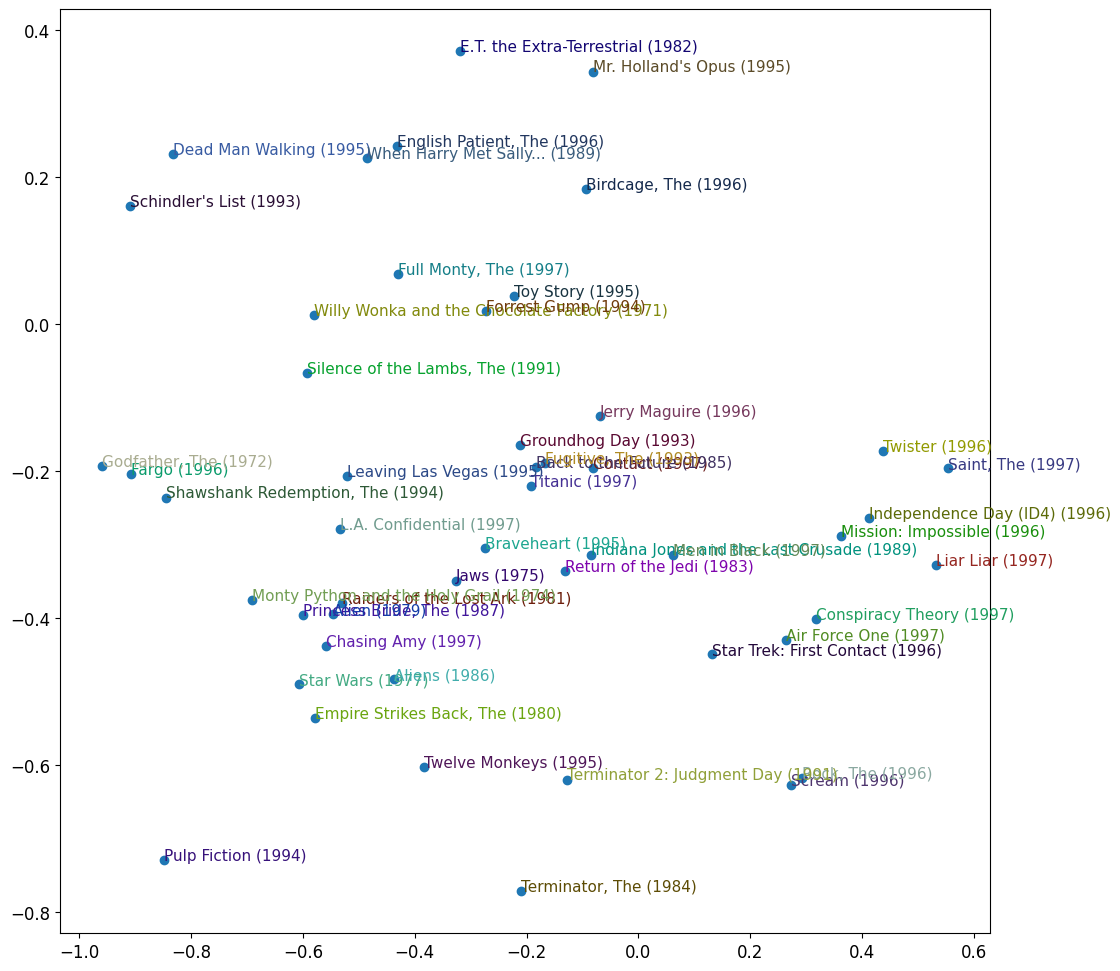

In [53]:
# need pca -- here, top 2 pcs
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])

movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)

fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]

plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
  plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

### Get embedding distance between movies
- Shows similarity/difference between pairs of movies
- General idea: movie similarity can be defined by the similarity of users that like those movies. And that directly means that the distance between two movies' embedding vectors can define that similarity

In [54]:
# find the movie most similar to silence of the lambs
movie_factors = learn.model.movie_factors#.weight

idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'Dial M for Murder (1954)'

## Automate this process with FastAI defaults:
- Uses dot product (aka probabilistic matrix factorization) -- same as above
- Note: this requires same size embeddings for users and movies (e.g., same size weights and bias embeddings for both users and movies)

In [55]:
# the dot-product (weights and bias) model is defined automatically
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.927434,0.956346,00:09
1,0.882253,0.877165,00:09
2,0.761615,0.830462,00:09
3,0.593923,0.820666,00:09
4,0.498506,0.820996,00:09


In [56]:
# look at the model and the self parameters
  # notice that the user and item (movie) weight embedding matrices are the same size -- 50 weights (latent factors)
  # and the user and item (movie) biases are the same size -- 1 bias factor
print(n_users, n_movies)
learn.model

944 1665


EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [57]:
# examine movie bias results -- same as above
movie_bias = learn.model.i_bias.weight.squeeze()

# get movie titles with the lowest values in the bias vector -- same as above
low_idxs = movie_bias.argsort()[:5]
print("LOWEST BIAS MOVIES")
print([dls.classes['title'][i] for i in low_idxs])

LOWEST BIAS MOVIES
['Children of the Corn: The Gathering (1996)', 'Robocop 3 (1993)', 'Lawnmower Man 2: Beyond Cyberspace (1996)', 'Crow: City of Angels, The (1996)', 'Beautician and the Beast, The (1997)']


# Collaborative Filterning Using Deep Learning
- Instead of taking the dot product, concatenate the embeddings and pass them through a NN
- Note: this allows DIFFERENT size embeddings for users and movies (e.g., weights and bias embeddings can be different sizes for users and movies). In other words, you can have different numbers of latent factors for movies and users.
- The deep learning approach is better than the PMF approach because now we can directly incorporate other user and movie information, date and time information, or any other information that may be relevant to the recommendation (we will do this in later chapters)

### Create model architecture manually
Note: EmbeddingNN is just a TabularModel, with n_cont=0 and out_sz=1 (n_cont = 0 means no continuous variables in the model)

In [58]:
class CollabNN(Module):
  def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
    self.user_factors = Embedding(*user_sz) # user embeddings / latent parameters
    self.item_factors = Embedding(*item_sz) # movie embeddings / latent parameters

    # NN
    self.layers = nn.Sequential(
      # linear layer 1
        # inputs = user_embeddings x movie embeddings
        # output = n_act features (number of activations) -- here, 100 is default
      nn.Linear(user_sz[1]+item_sz[1], n_act),

      # rectified linear unit ("nonlinearity")
        # replace every negative number with a 0
      nn.ReLU(),

      # linear layer 2
        # inputs = n_act "activations" (same as number of outfut of linear layer 1)
        # output = 1 feature (a single activation)
      nn.Linear(n_act, 1)
    )
    self.y_range = y_range

  # applies the embeddings to the NN (instead of creating the dot product)
  def forward(self, x):
    embs = self.user_factors(x[:,0]),self.item_factors(x[:,1]) # apply embeddings
    x = self.layers(torch.cat(embs, dim=1)) # concatenate the results
    smoothed_x = sigmoid_range(x, *self.y_range) # smooth range to the y-values (same as before)
    return smoothed_x

#### Find best embedding sizes for users / movies

In [59]:
# find the best embedding size automatically
# embeddings are concatenated here, so no separate weights and bias embeddings
print(n_users, n_movies)
embs = get_emb_sz(dls)
embs

944 1665


[(944, 74), (1665, 102)]

#### Create model
Use the size of embeddings found above

In [60]:
model = CollabNN(*embs)

#### Define learner and fit

In [61]:
# define learner
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

print(n_users, n_movies)
learn.model

epoch,train_loss,valid_loss,time
0,0.918603,0.945734,00:10
1,0.919003,0.906242,00:10
2,0.842772,0.879992,00:10
3,0.808544,0.866005,00:10
4,0.744757,0.869607,00:10


944 1665


CollabNN(
  (user_factors): Embedding(944, 74)
  (item_factors): Embedding(1665, 102)
  (layers): Sequential(
    (0): Linear(in_features=176, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)

### Do this automatically with FastAI defaults
This uses the same NN (ColabNN class) we made above

In [62]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5)) # calls get_emb_sz automatically
learn.fit_one_cycle(5, 5e-3, wd=0.1)

print(n_users, n_movies)
learn.model

epoch,train_loss,valid_loss,time
0,0.958242,0.979675,00:11
1,0.889243,0.916957,00:10
2,0.857584,0.871181,00:10
3,0.810886,0.850907,00:11
4,0.723904,0.854098,00:11


944 1665


EmbeddingNN(
  (embeds): ModuleList(
    (0): Embedding(944, 74)
    (1): Embedding(1665, 102)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=176, out_features=50, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=50, out_features=1, bias=True)
    )
    (2): fastai.layers.SigmoidRange(low=0, high=5.5)
  )
)

### Add 2 hidden layers in the model
This uses the same NN we made above -- but adds 2 hidden layers

In [63]:
# add two hidden layers (size 100 and 50)
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

print(n_users, n_movies)
learn.model

epoch,train_loss,valid_loss,time
0,0.983002,0.981017,00:12
1,0.945604,0.907709,00:12
2,0.871737,0.887267,00:12
3,0.823383,0.857633,00:12
4,0.743036,0.859982,00:12


944 1665


EmbeddingNN(
  (embeds): ModuleList(
    (0): Embedding(944, 74)
    (1): Embedding(1665, 102)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=176, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=100, out_features=50, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=50, out_features=1, bias=True)
    )
    (3): fastai.layers.SigmoidRange(low=0, high=5.5)
  )
)